In [1]:
import sys
import os

def configure_spark(spark_home=None, pyspark_python=None):
    spark_home = spark_home or "/path/to/default/spark/home"
    os.environ['SPARK_HOME'] = spark_home

    # Add the PySpark directories to the Python path:
    sys.path.insert(1, os.path.join(spark_home, 'python'))
    sys.path.insert(1, os.path.join(spark_home, 'python', 'pyspark'))
    sys.path.insert(1, os.path.join(spark_home, 'python', 'build'))

    # If PySpark isn't specified, use currently running Python binary:
    pyspark_python = pyspark_python or sys.executable
    os.environ['PYSPARK_PYTHON'] = pyspark_python
    
configure_spark('/usr/local/spark', '/home/ubuntu/anaconda3/envs/dat500/bin/python')

In [2]:
import argparse
import findspark
findspark.init()
import pyspark
from pyspark import SQLContext
sc = pyspark.SparkContext(master='spark://192.168.11.239:7077', appName='hourly_forecaster')
sqlContext = SQLContext(sc)

In [3]:
from datetime import datetime
import pyspark.sql.functions as F #avoid conflicts with regular python functions
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType
from pyspark.sql.types import *
import pandas as pd
os.environ["ARROW_PRE_0_15_IPC_FORMAT"] = "0"
from fbprophet import Prophet
import matplotlib.pyplot as plt
from fbprophet.plot import plot_plotly
import plotly.offline as py
import holidays
import numpy as np
import time

In [4]:
def generate_US_holidays(start,end,state="IL"):
    hdays = holidays.UnitedStates(years=list(np.arange(start,end+1)),state=state).items()
    hdays = dict(list(hdays)) #Convert to dict since it is immutable
    return {str(k):v for k,v in hdays.items()} #Want Y-m-d format

us_hdays = generate_US_holidays(2001,2020)

In [5]:
@udf(StringType())
def holiday_desc(_date):
    if str(_date) in us_hdays.keys():
        return us_hdays[str(_date)]
    else:
        return "None"

Add holiday description as a column on the dataframe

In [6]:
schema = StructType([
        StructField("District", StringType(), True),
        StructField("count", StringType(), True),
        StructField("ds", DateType(), True),
        StructField("yhat", DoubleType(), True)
    ])

## Forecast data in parallel using Pandas UDFs

This strategy is heavily inspired by:
https://github.com/AlexWarembourg/Medium/blob/master/Pyspark_Pandas_UDF.ipynb

In [7]:
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def prophet_udf(df):
    
    def train_predict_prophet(df, cutoff):
        ts_train = (df
                    .query('Day <= @cutoff_point')
                    .rename(columns={'Day': 'ds', 'count': 'y'})
                    .sort_values('ds')
                    )
        ts_test = (df
                   .query('Day > @cutoff_point')
                   .rename(columns={'Day': 'ds', 'count': 'y'})
                   .sort_values('ds')
                   .assign(ds=lambda x: pd.to_datetime(x["ds"]))
                   .drop('y', axis=1)
                   )

        m = Prophet(yearly_seasonality=5,
                    weekly_seasonality=45)
        m.fit(ts_train)
        df["Day"] = pd.to_datetime(df["Day"])

        
        ts_hat = (m.predict(ts_test)[["ds", "yhat"]]
                  .assign(ds=lambda x: pd.to_datetime(x["ds"]))
                  ).merge(ts_test, on=["ds"], how="left")  # merge to retrieve item and store index
        return pd.DataFrame(ts_hat, columns=schema.fieldNames())

    return train_predict_prophet(df, cutoff_point)

In [9]:
df_train = sqlContext.read.csv("/datasets/crimes.csv", header='true')\
.filter( (F.col("Year") < 2020) )\
.filter( (F.col("District")!='021') & (F.col("District")!='031'))\
.withColumn('Day', F.to_date("Date", 'MM/dd/yyyy hh:mm:ss a'))\
.withColumn('holiday', holiday_desc(F.col('Day')))\
.select("Day","District","holiday")\
.groupBy("Day","District","holiday")\
.count()


df_test = sqlContext.read.csv("/datasets/crimes.csv", header='true')\
.filter((F.col("Year") == 2020))\
.filter( (F.col("District")!='021') & (F.col("District")!='031'))\
.withColumn('Day', F.to_date("Date", 'MM/dd/yyyy hh:mm:ss a'))\
.withColumn('holiday', holiday_desc(F.col('Day')))\
.withColumn("Month", F.month("Day"))\
.filter((F.col("Month")== 1))\
.select("Day","District","holiday")\
.groupBy("Day","District","holiday")\
.count()

print("Length of train: ", df_train.count())
print("Length of test: ", df_test.count())

cutoff_point = df_train.select(F.max(F.col('Day'))).collect()[0][0]
df = (df_train.union(df_test)).sort(F.col('Day'))


predictions = (df
              .groupBy("District")
              .apply(prophet_udf)
              )

start = time.time()
predictions = (predictions\
.withColumnRenamed("count","jcount")\
.withColumnRenamed("District","jDistrict"))
#Print an example from district 008
print(predictions.filter(F.col("District")=="008").show(10))
print("Predicted for all districts in ", round((time.time() - start ),2), " seconds")

Length of train:  152658
Length of test:  660
+---------+------+----------+------------------+
|jDistrict|jcount|        ds|              yhat|
+---------+------+----------+------------------+
|      008|  null|2020-01-01| 36.01105253638667|
|      008|  null|2020-01-02| 35.53283898891453|
|      008|  null|2020-01-03|38.964116222101126|
|      008|  null|2020-01-04|35.346469253003704|
|      008|  null|2020-01-05| 32.62074038282281|
|      008|  null|2020-01-06| 35.82805465895612|
|      008|  null|2020-01-07| 35.17704124862421|
|      008|  null|2020-01-08| 35.62225395062029|
|      008|  null|2020-01-09| 35.13543083100051|
|      008|  null|2020-01-10| 38.55677766771585|
+---------+------+----------+------------------+
only showing top 10 rows

None
Predicted for all districts in  166.78  seconds


In [10]:
predictions = df_test.join(predictions,\
              ([predictions.ds == df_test.Day,\
                predictions.jDistrict == df_test.District]),\
              how='left')\
.select("Day","District", "count", "yhat")

predictions.show(5)

+----------+--------+-----+------------------+
|       Day|District|count|              yhat|
+----------+--------+-----+------------------+
|2020-01-12|     001|   28| 32.52679365179546|
|2020-01-15|     006|   40|40.732364832043615|
|2020-01-30|     009|   22| 21.88572672451624|
|2020-01-01|     004|   34| 32.51587347399825|
|2020-01-16|     025|   44|28.485887557514324|
+----------+--------+-----+------------------+
only showing top 5 rows



In [11]:
pred_df = predictions.toPandas().sort_values(by = "Day").reset_index(drop=True)

No handles with labels found to put in legend.


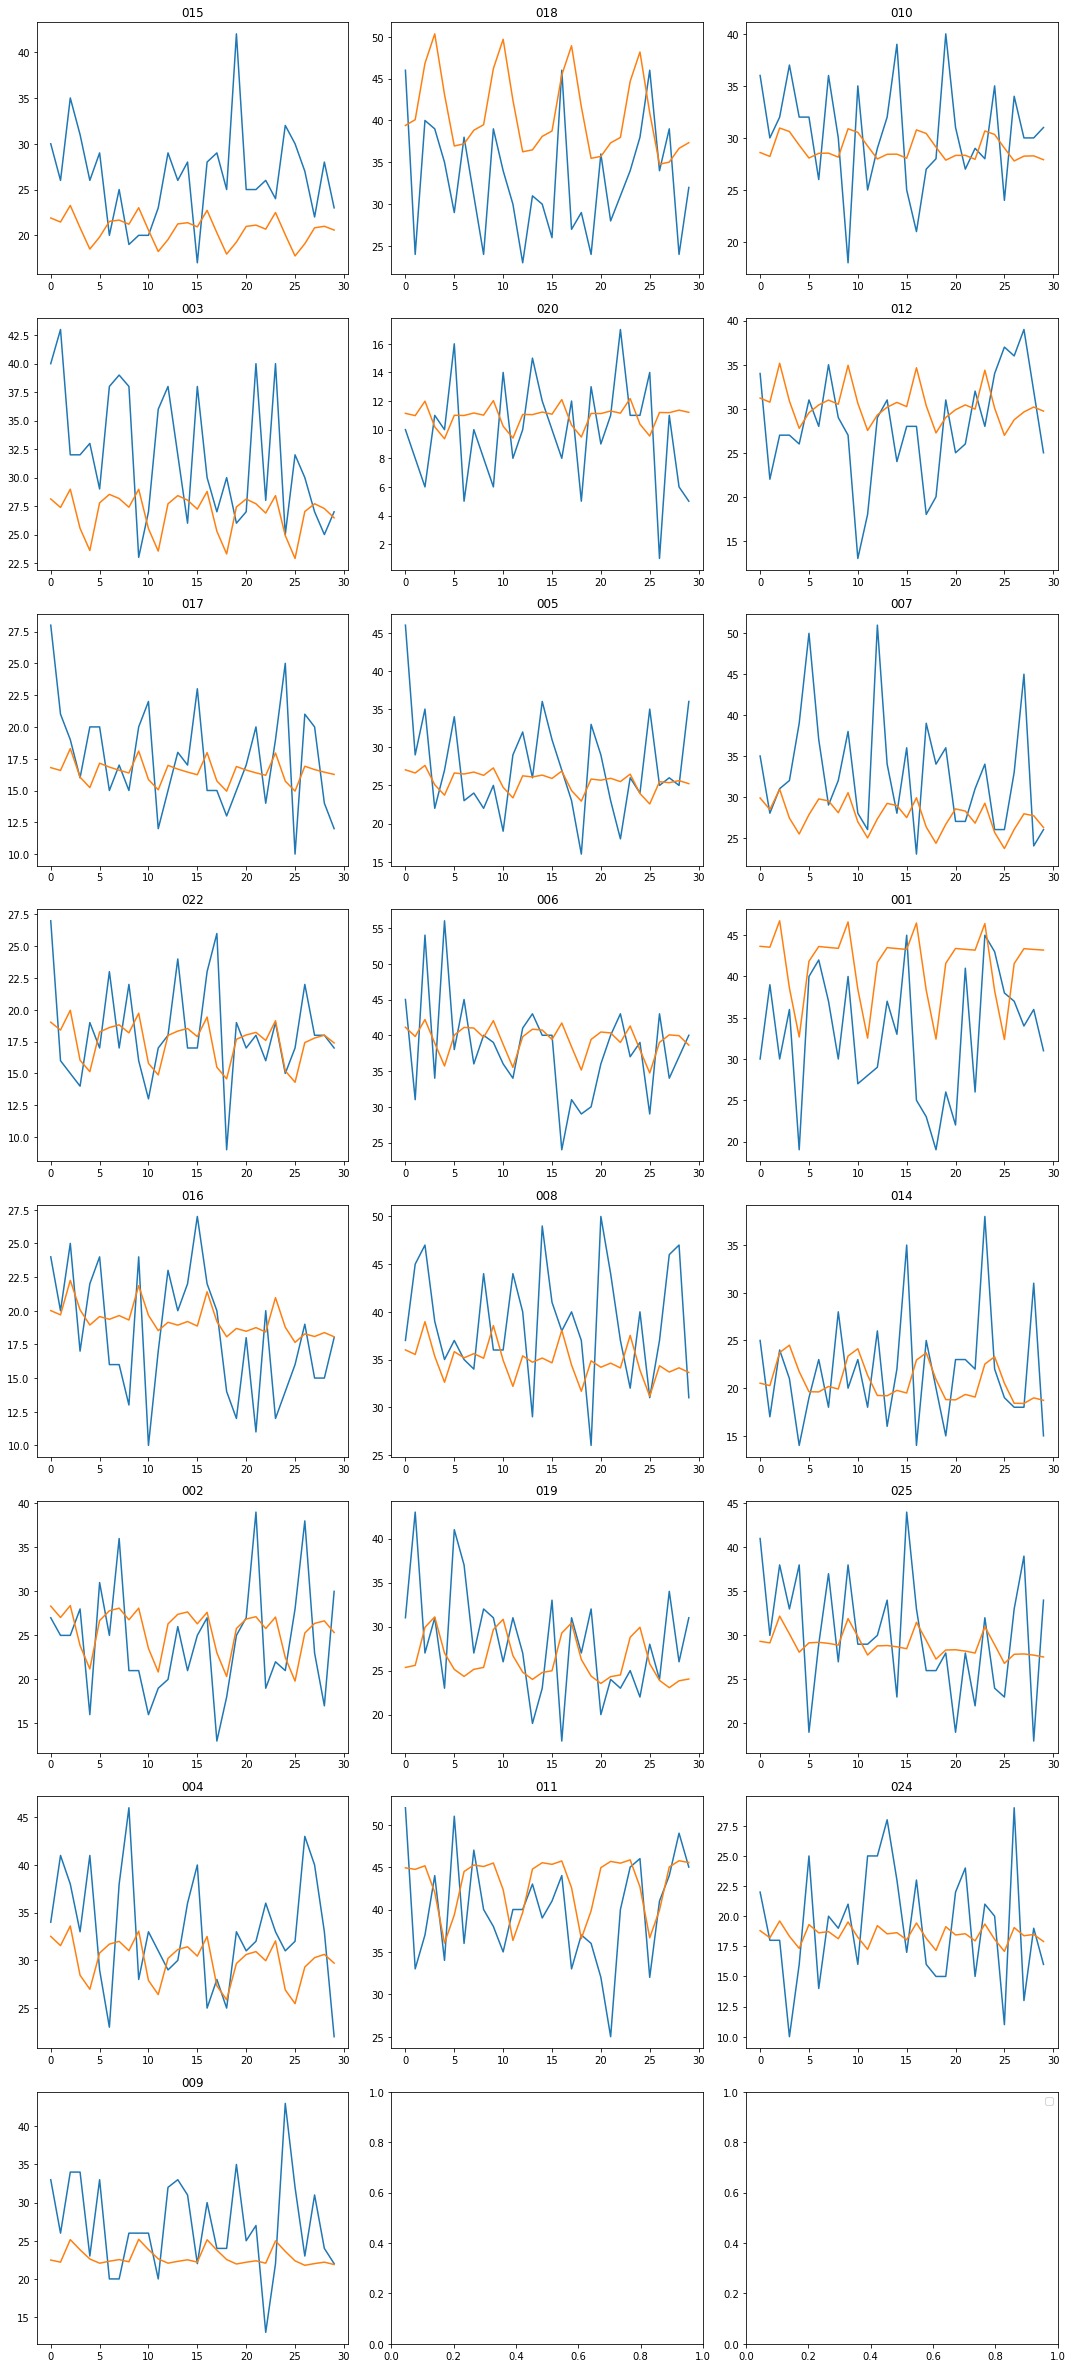

In [12]:
fig,ax = plt.subplots(8,3, sharex=False, sharey=False,figsize=(15,33))
col = 0
row = 0
init = True
for dist in pred_df.District.unique():
        col = col % 3
        if not init and col == 0:
            row = row + 1
        init = False
        
        ax[row][col].set_title(str(dist))
        for j in ["count","yhat"]:
            y = pred_df[pred_df.District == dist][j].values
            x = np.arange(0,len(y))
            ax[row][col].plot(x, y, label=str(j))
              
        col += 1
        

plt.tight_layout()
plt.legend()
plt.show()

This model was not able to predict well for any district